## Implementation of Blackjack to simulate various card counting strategies ##

### Read me ###
See https://github.com/jmausolf/poshmark_sharing READ_ME.md for proper styling and content



In [525]:
import random
from timeit import default_timer as timer
import time

### 1. Implementation of Blackjack game with parameters for various rulesets ###

In [526]:
class colour:
    '''Colour class used for cleaner printing to terminal'''
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [527]:
class Deck():
    '''Deck class used to store and manipulate a data type emulating a playing card deck'''
    def __init__(self, num_of_decks=1):
        self.deck = [i%52 for i in range(num_of_decks*52)]
        self.discard_deck = []
        
    def shuffle(self):
        random.shuffle(self.deck)
    
    def card_num_or_face(self, num):
        num_or_face = {0: 'Ace', 1: '2', 2: '3', 3: '4', 4: '5', 5: '6', 6: '7', 7: '8',
                       8: '9', 9: '10', 10: 'Jack', 11: 'Queen', 12: 'King'}
        return num_or_face[num%13]
    
    def card_suit(self, num):
        suits = {0: 'Hearts', 1: 'Diamonds', 2: 'Clubs', 3: 'Spades'}
        return suits[num//13]
    
    def new_card_suit(self, num):
        suits = {0: '\u2665',  # Hearts
                 1: '\u2662',  # Diamonds
                 2: '\u2663',  # Clubs
                 3: '\u2664'}  # Spades
        return suits[num//13]
    
    def read_card(self, num, formatted=True):
        if formatted:
            if (self.card_suit(num) == 'Hearts') or (self.card_suit(num) == 'Diamonds'):
                col_text = colour.RED + colour.BOLD
            else:
                col_text = colour.BOLD
        return col_text + self.card_num_or_face(num) + ' of ' + self.new_card_suit(num) + colour.END

In [787]:
class Player():
    '''Player class to emulate blackjack player'''
    def __init__(self, name, num, bankroll=0):
        self.name = name
        self.num = num
        self.bankroll = bankroll
        self.bet = 0
        self.current_hand = []
        self.hand_values = []
        self.hand_best_value = 0
        self.insurance_bet = 0
        
        self.children = []
        
    def update_bankroll(self, cash_to_add):
        self.bankroll += cash_to_add
                
    def get_bankroll(self):
        return self.bankroll
        
    def update_children(self, child):
        self.children.append(child)
        
    def get_num_children(self):
        return len(self.children)
    
    def reset_children(self):
        self.children = []
    

In [788]:
class Player_Split(Player):
    '''Player Split class emulates player after splitting a hand. Inherits from player parent'''
    # Player parent variable to reference
    def __init__(self, player_parent, player1_or_2):
        self.player_parent = player_parent  # Store parent player
        self.player_parent.update_children(self)  # Update parent player variable of number of children
        self.name = player_parent.name + ' Hand ' + str(self.player_parent.get_num_children())
        
        self.num = player_parent.num
        self.bankroll = player_parent.bankroll
        self.bet = player_parent.bet
        self.current_hand = [player_parent.current_hand[player1_or_2-1]]  # Split takes first card only
        self.hand_values = player_parent.hand_values
        self.hand_best_value = player_parent.hand_best_value
        self.insurance_bet = 0
        
    def update_bankroll(self, cash_to_add):
        self.player_parent.update_bankroll(cash_to_add)  # Update bankroll of parent
        
    def get_bankroll(self):
        return self.player_parent.get_bankroll()
    
    def update_children(self, child):
        self.player_parent.update_children(child)
        
    def get_num_children(self):
        return self.player_parent.get_num_children()


In [530]:
class Dealer(Player):
    '''Dealer class to emulate the dealers current hand. Inherits from Player()'''
    def __init__(self):
        self.current_hand = []
        self.hand_values = []
        self.hand_best_value = 0

In [1000]:
class InputOutput():
    '''InputOutput class to control any input or output whilee playing Blackjack.
       Options to print to terminal or not for large simulations.
       Segregation of code into its own class allows a UI to be implemented here in the future'''
    def __init__(self, card_counter, print_to_terminal=True):
        # Initiate card counting object from blackjack game to use for machine m oves
        self.card_counter = card_counter
        self.basicstrategy = BasicStrategy()
        
        self.print_to_terminal = print_to_terminal

    def terminal(self, msg):
        if self.print_to_terminal:
            print(msg)
        
    def welcome(self):
        self.terminal('Welcome to Blackjack')
        
    def get_player_input(self, player, split, deck_obj, dealer, human_player=True):
        while True:
            if human_player:
                value = input('Player {} ({}) what is is your move? '
                              '(HIT, STAND, DD, SPLIT, SURR, INSUR): '.format(player.num, player.name))
                value = value.upper()  # Uppercase it

                if 'HIT' in value:
                    return 0
                elif 'STAND' in value:
                    return 1
                elif 'DD' in value:
                    if self.can_double_down(player):
                        return 2
                elif 'SPLIT' in value:
                    if split == True:
                        return 3
                    else:
                        print('You cannot split with a {}'.format(self.hand_to_print(deck_obj, player.current_hand)))
                elif 'SURR' in value:
                    if self.can_surrender(player):
                        return 4
                elif 'INSUR' in value:
                    if can_insure(player, dealer, deck_obj):
                        return 5
                else:
                    print('Incorrect input. Please try again.')  
            else:  # ADD MACHINE HERE LATER
                move = self.basicstrategy.get_move(player, dealer)
                if move == 'H':  # Hit
                    return 0
                elif move == 'S':  # Stand
                    return 1
                elif move == 'D':  # Double down
                    if self.can_double_down(player):
                        return 2
                    else:
                        self.terminal('Hit instead')
                        return 0  # Hit if no bankroll to double down
                elif move == 'P':  # Split
                    if split==True:
                        return 3
                    else:
                        raise ValueError('Basic strategy trying to split non splittable hand')
                elif move == 'SS':  # Surrender
                    if self.can_surrender(player):
                        return 4
                    else:
                        raise ValueError('Basic strategy is trying to surrender')
                elif move == 'U':  # Insurance
                    if self.can_insure(player, dealer, deck_obj):
                        return 5
                    else:
                        raise ValueError('Basic strategy is trying to insure')
                else:
                    raise ValueError('Basic strategy returning non programmed move ({})'.format(move))
                
                # Function returns best strategy and average payout. Then recursion multiply average payout?
                
                raise ValueError('No computer player implemented')
                
    def can_double_down(self, player):
        if player.bankroll < player.bet * 2:
            self.terminal('Bankroll not enough to double')
            return False
        elif len(player.current_hand) > 2:
            self.terminal('You cannot double down unless you are on the first turn')
            return False
        else:
            return True
        
    def can_surrender(self, player):
        if len(player.current_hand) <= 2:
            return True
        else:
            self.terminal('You cannot surrender unless you are on the first turn')
            return False
        
    def can_insure(self, player, dealer, deck_obj):
        if deck_obj.card_num_or_face(dealer.current_hand[0]) != 'Ace':
            self.terminal('You can only insure if dealer has face up Ace')
            return False
        elif player.bankroll < (player.bet + player.bet//2):
            self.terminal('You do not have enough bankroll to insure')
            return False
        elif player.insurance_bet != 0:
            self.terminal('You have already taken insurance on this hand')
            return False
        else:
            return True

                
    def hand_to_print(self, deck_obj, player_hand):
        str_to_print = deck_obj.read_card(player_hand[0])
        for hand in player_hand[1:]:
                    str_to_print += ' and {}'.format(deck_obj.read_card(hand))
        return str_to_print
                
    def new_card_dealt(self, player_name, player_num):
        pass
                
    def player_current_hand(self, player, deck_obj):
        str_to_print = 'Player {} ({}): You have {} - {}'.format(player.num, player.name,
                        self.hand_to_print(deck_obj, player.current_hand), player.hand_values)
        self.terminal(str_to_print)
        
    def player_current_hand_vs_dealer(self, player, dealer, deck_obj):
        str_to_print = 'Player {} ({}): You have {} - {} vs dealer {}'.format(player.num, player.name,
                        self.hand_to_print(deck_obj, player.current_hand), player.hand_best_value, dealer.hand_best_value)
        self.terminal(str_to_print)
        
    def dealer_current_hand(self, dealer, deck_obj):
        self.terminal('Dealer has a ' + deck_obj.read_card(dealer.current_hand[0]))
        
    def blackjack(self):
        self.terminal('Blackjack!')

    def bust(self):
        self.terminal('Bust!')
        
    def hit(self, new_card, deck_obj, player):
        self.terminal('HIT: next card {} - {}'.format(deck_obj.read_card(new_card), player.hand_values))

    def double_down(self, new_card, deck_obj, player):
        self.terminal('Player {} ({}) double down. Player bet doubled from ${} to ${}'.format(player.num, player.name,
                        player.bet//2, player.bet))
        self.terminal('HIT: next card {} - {}'.format(deck_obj.read_card(new_card), player.hand_values))
        
        # Check if they got a blackjack or went bust and if so tell them
        if player.hand_values == 'Blackjack':
            self.blackjack()
        elif min(player.hand_values) > 21:  # player went bust
            self.bust()
            
    def split(self, player):
        self.terminal('Player {} ({}) split'.format(player.num, player.name))
        
    def surrender(self, player):
        self.terminal('Player {} ({}) surrender. Half bet (${}) forfeited'.format(player.num, player.name, player.bet//2))
    
    def insurance(self, player):
        pass
        
    def print_all_hands(self, player):  # Unused
        for i, player in enumerate(self.players):
                player_value = self.get_player_value(player.current_hand)
                str_to_print = 'Player {} ({}): You have {} - {}'.format(str(i+1), player.name,
                                self.hand_to_print(player.current_hand), player_value)
                self.terminal(str_to_print)
                
    def dealer_flip_card(self, dealer, deck_obj):
        self.terminal('Dealer goes:')
        self.terminal('Dealer has {}'.format(deck_obj.read_card(dealer.current_hand[0])))
        self.terminal('Dealer flips over {} - {}'.format(deck_obj.read_card(dealer.current_hand[1]), 
                                                     dealer.hand_values))
        
    def payout(self, player, player_payout, original_bankroll, new_bankroll):
        self.terminal('Bet of ${} payout {}x. Bankroll ${}->${}'.format(player.bet, player_payout, original_bankroll, 
                                                                    new_bankroll))
        
    def insurance_payout(self, player, insurance_payout):
        if insurance_payout > 0:  # Insurance bet taken and won
            self.terminal('Insurance bet of ${} won. Paid out ${}'.format(player.insurance_bet, insurance_payout))
        elif insurance_payout < 0:  # Insurance bet taken and loss
            self.terminal('Insurance bet of ${} lost'.format(player.insurance_bet))
        else:  # No insurance bet taken
            pass
                
                
    def get_user_bets(self, player, human_player=True):
        collecting_input = True
        while collecting_input:
            # Get user input
            if human_player:
                bet = input('Player {} ({}) place your bet (Bankroll ${}): '.format(player.num, player.name, player.bankroll))
            else:
                bet = self.card_counter.get_suggested_bet()
                self.terminal(('Player {} ({}) has bankroll ${} and bet ${}): '.format(player.num, player.name, player.bankroll, bet)))
            try:
                bet = int(bet)
            except TypeError:
                print('Incorrect input, please input an integer')

            # Check they have enough
            if player.bankroll < bet:
                print('{} you do not have enough bankroll to bet ${}. ' 
                      'Current bankroll ${}'.format(player.name, bet, player.bankroll))
            else:
                collecting_input = False

        self.terminal('')
        return bet




In [1142]:
class Blackjack():
    '''Blackjack game simulator. Default ruleset is based off of a liberal Vegas shoe but customisable'''
    def __init__(self, players, num_of_decks=6, 
                 blackjack_payout=1.5, win_payout=1, push_payout=0, loss_payout=-1, surrender_payout=-0.5,
                 dealer_stand_on_hard=17, dealer_stand_on_soft=17,
                 shuffle_deck=True,
                 late_surrender = True, early_surrender = False,
                 player_bankroll=1000, reshuffle_penetration=0.75,
                 human_player=True, print_to_terminal=True,
                 min_bet=1, bet_spread=8,
                 dealer_peeks_for_bj=False,
                 strategy_name='hi_lo'):
        
        self.num_of_decks = num_of_decks
        self.human_player = human_player
        self.print_to_terminal = print_to_terminal
        
        self.min_bet = min_bet
        self.bet_spread = bet_spread
        
        self.dealer_peeks_for_bj = dealer_peeks_for_bj
        self.strategy_name = strategy_name
        
        # Card counting class to initiate
        self.card_counter = Card_Counter(self, total_decks=self.num_of_decks, strategy_name=strategy_name,
                                         min_bet=self.min_bet, bet_spread=self.bet_spread)

        # Initiate input/output means
        self.inputoutput = InputOutput(self.card_counter, print_to_terminal=self.print_to_terminal)
        
        # Initiate deck object
        self.deck_obj = Deck(num_of_decks)
        
        # Create player objects for each player
        self.players = []
        for i, player_name in enumerate(players):
            self.players.append(Player(name=player_name, num=i+1, bankroll=player_bankroll))
            
        # Create dealer object
        self.dealer = Dealer()
        
        # Initiate payout parameters
        self.blackjack_payout = blackjack_payout
        self.win_payout = win_payout
        self.push_payout = push_payout
        self.loss_payout = loss_payout
        self.surrender_payout = surrender_payout
        
        # Other rules
        self.dealer_stand_on_hard = dealer_stand_on_hard
        self.dealer_stand_on_soft = dealer_stand_on_soft
        
        # Surrender rules - late is the norm. Early is +0.6% advantage
        self.late_surrender = late_surrender
        self.early_surrender = early_surrender
        
        
        # Shuffle parm
        self.reshuffle_penetration = reshuffle_penetration
        
        # Shuffle deck
        if shuffle_deck:
            self.shuffle()
    
    def shuffle(self, discard_top_card=True, re_add_discard_deck=False):
        if re_add_discard_deck:  # Add discard deck back
            for _ in range(len(self.deck_obj.discard_deck)):
                self.deck_obj.deck.append(self.deck_obj.discard_deck.pop())
            self.card_counter.deck_refreshed() # inform card_counter class
                
        self.deck_obj.shuffle()  # Shuffle deck
        if discard_top_card:  # Discard top card
            self.deck_obj.discard_deck.append(self.deck_obj.deck.pop())
        
    def display_deck(self):
        for card in self.deck_obj.deck:
            print(self.deck_obj.read_card(card))
            
    def deal_card(self, player, update_values=True):
        # Deal new card
        new_card = self.deck_obj.deck.pop()
        player.current_hand.append(new_card)
        
        # Update hand values
        if update_values:
            self.update_hand_values(player)
            
        # Send new card to card_counter class
        self.card_counter.next_card(new_card)

        return new_card
    
    def update_hand_values(self, player):
        player.hand_values = self.get_player_value(player.current_hand)
        player.hand_best_value = self.best_player_value(player)
    
    def is_blackjack(self, card1, card2):
        if (card1 < 0) or (card2 < 0):  # If ace in value calc
            return False
        card1_value = card1%13
        card2_value = card2%13
        
        # Ace = 0, 10-King = 9-12
        if (card1_value == 0 and card2_value >= 9 and card2_value <= 12) or \
           (card2_value == 0 and card1_value >= 9 and card1_value <= 12):
            return True
        return False
    
    def get_player_value(self, player_hand, first_run=True):
        if len(player_hand) > 1 and self.is_blackjack(player_hand[0], player_hand[1]):
            return 'Blackjack'
        
        if first_run:
            self.player_values = []  # store as list so can have multiple if soft values. Class variable for recursion
        
        player_value = 0
        for i, card in enumerate(player_hand):
            card_value = card%13
            if card_value == 0:  # Ace
                new_hand_1 = player_hand.copy()
                new_hand_2 = player_hand.copy()
                
                new_hand_1[i] = -1  # Ace as 1
                new_hand_2[i] = -2  # Ace as 11
                
                self.get_player_value(new_hand_1, first_run=False)
                self.get_player_value(new_hand_2, first_run=False)
                
                break
            else:
                if card == -1:  # Then this is soft 1 ace
                    card_value = 1
                elif card == -2:  # Then this is soft 11 ace
                    card_value = 11
                elif card_value >= 9:  # Then this is 10 or face card
                    card_value = 10
                else:  # Any other card increment by 1 for correct number
                    card_value += 1
                    
                player_value += card_value
        else:  # If there wasn't a 0 signifying un-declared Ace then append to list
            self.player_values.append(player_value)
            
        if first_run:
            return self.player_values
        
    def best_player_value(self, player):   
        # If Blackjack
        if player.hand_values == 'Blackjack':
            return player.hand_values
        
        # If only 1 then return value
        if len(player.hand_values) == 1:
            return player.hand_values[0]
        else:  # Max value less than 21
            best_value = player.hand_values[0]
            for value in player.hand_values[1:]:
                if value > best_value and value <= 21:
                    best_value = value
            return best_value
            
    def get_dealer_input(self, dealer_value):
        # Dealer play adjusted by ruleset inputs

        # Hard values
        if len(dealer_value) == 1:
            if dealer_value[0] >= self.dealer_stand_on_hard:
                return 1  # STAND
            else:
                return 0  # HIT

        # Soft values
        for value in dealer_value:
            if value >= self.dealer_stand_on_soft and value <= 21:
                return 1  # STAND
        return 0  # HIT
    
    def player_play(self, player, i=None, print_to_console=True):
        turn_complete = False
        while not turn_complete:       
            if print_to_console:
                self.inputoutput.player_current_hand(player, self.deck_obj)
                
                self.inputoutput.dealer_current_hand(self.dealer, self.deck_obj)

            if player.hand_values == 'Blackjack':  # player has blackjack
                self.inputoutput.blackjack()
                turn_complete = True
            elif min(player.hand_values) > 21:  # player went bust
                self.inputoutput.bust()
                turn_complete = True
            else:
                # Check if player can split
                split = False
                if (len(player.current_hand) == 2) and \
                (self.deck_obj.card_num_or_face(player.current_hand[0]) == \
                 (self.deck_obj.card_num_or_face(player.current_hand[1]))):
                    split = True

                # Player action
                if type(player) is Player or type(player) is Player_Split:
                    player_action = self.inputoutput.get_player_input(player, split, self.deck_obj, 
                                                                      self.dealer, human_player=self.human_player)
                elif type(player) is Dealer:
                    player_action = self.get_dealer_input(player.hand_values)

                if player_action == 0:  # HIT
                    print_to_console = False  # Don't print full hand next run
                    new_card = self.deal_card(player)  # Deal next card

                    self.inputoutput.hit(new_card, self.deck_obj, player)

                elif player_action == 1:  # STAND
                    turn_complete = True
                elif player_action == 2:  # DOUBLE DOWN
                    # Double player's bet
                    assert (player.bankroll >= player.bet * 2) and (len(player.current_hand) <= 2)
                    player.bet = player.bet * 2
                    
                    # Deal new card
                    new_card = self.deal_card(player)  # Deal next card
                    turn_complete = True # User's turn complete

                    # Output double down to player
                    self.inputoutput.double_down(new_card, self.deck_obj, player)
                    
                elif player_action == 3:  # SPLIT
                    assert (len(player.current_hand) == 2) and \
                    (self.deck_obj.card_num_or_face(player.current_hand[0]) == \
                     (self.deck_obj.card_num_or_face(player.current_hand[1])))
                    # If player can split then create new player_split objects for each and add them to self.players
                    player_split_1 = Player_Split(player, 1)
                    player_split_2 = Player_Split(player, 2)
                    
                    # Update hand values
                    self.update_hand_values(player_split_1)
                    self.update_hand_values(player_split_2)

                    # Delete cards from original player's hand
                    player.current_hand = []
                    
                    # Add new players to the self.players list so they are called right after this loop
                    for i, ele in enumerate(self.players):
                        if ele is player:
                            self.players.insert(i+1, player_split_1)
                            self.players.insert(i+2, player_split_2)
                    
                    # Output split move to user
                    self.inputoutput.split(player)
                    
                    turn_complete = True

                elif player_action == 4:  # SURRENDER
                    # Must be first player move and whether works vs blackjack is early/late parameter
                    assert len(player.current_hand) <= 2  # Allows surr right after split by default
                    player.hand_best_value = 'Surrender'
                    
                    # Output surrender move to user
                    self.inputoutput.surrender(player)
                    
                    turn_complete = True
                
                elif player_action == 5:  # INSURANCE
                    # Insurance against face up Ace gets you half bet back if blackjack. Usually never optimal.
                    # There are other insurance variations which could be implemented here:
                    # https://www.qfit.com/blackjack-rules-surrender.htm
                    # Note: insurance is only worthwhile if more 10 cards than non in deck
                    # 9 to 4 odds and 2 to 1 payout
                    # Insure for half of current bet by default: could make dynamic in future
                    assert self.deck_obj.card_num_or_face(self.dealer.current_hand[0]) == 'Ace'  # First turn
                    assert player.bankroll >= (player.bet + player.bet//2)  # They have enough cash
                    assert player.insurance_bet == 0. # They haven't already taken insurance
                    player.insurance_bet = player.bet//2
                    
                    # Output insurance move to user
                    self.inputoutput.insurance(player)
                    
                else:
                    raise ValueError('Error: player action is not an integer 0-4')
                    
        if self.print_to_terminal:
            print('')
        #time.sleep(1.5)
                
    def compare_hands(self, player, dealer):
        # Takes in hands and returns and payout
        
        
        if player.hand_best_value=='Blackjack':  # Player blackjack
            if dealer.hand_best_value=='Blackjack':  # Dealer blackjack
                return self.push_payout
            else:
                return self.blackjack_payout
        
        if dealer.hand_best_value=='Blackjack':  # Dealer only blackjack
            if player.hand_best_value=='Surrender' and self.early_surrender:  # Early surrender vs blackjack
                return self.surrender_payout
            else:
                return self.loss_payout
            
        if player.hand_best_value=='Surrender':  # Late surrender
            return self.surrender_payout
            
        if player.hand_best_value > 21:  # Player went bust
            return self.loss_payout
        elif dealer.hand_best_value > 21:  # Dealer went bust
            return self.win_payout

        if dealer.hand_best_value == player.hand_best_value:  # Same value
            return self.push_payout
        elif player.hand_best_value > dealer.hand_best_value:  # Player better value
            return self.win_payout
        elif player.hand_best_value < dealer.hand_best_value:  # Dealer better value
            return self.loss_payout
        else:
            raise ValueError('Error: player and dealer best value not compatible')
        
    def discard_hand(self, player):
        while len(player.current_hand) > 0:
            self.deck_obj.discard_deck.append(player.current_hand.pop())
    
    def discard_all_hands(self):
        for player in self.players:
            self.discard_hand(player)
        self.discard_hand(self.dealer)
            
    def take_bets(self):
        # 1. Bet amount is logged into private variable
        for player in self.players:
            player.bet = self.inputoutput.get_user_bets(player, human_player=self.human_player)
            
    def check_insurance_payout(self, player):
        if player.insurance_bet > 0:
            if dealer.best_player_value=='Blackjack':
                return player.insurance_bet * 2
            else:
                return player.insurane_bet * -1
        return 0
            
    def play_hand(self):
        # 2. Dealer gives 1 card to player (each player if multiple)
        for player in self.players:
            self.deal_card(player)
            
        # 3. Dealer gives 1 card to themself face up
        self.deal_card(self.dealer)
        
        # 4. Dealer gives 2nd card to player (each player if multiple)
        for player in self.players:
            self.deal_card(player)
            
        # 5. Dealer gives 2nd card to themself. Dealt face down so don't reveal to player
        self.deal_card(self.dealer)
        
        # 6. Dealer peeks / does not peek for Blackjack
        if self.dealer_peeks_for_bj and self.dealer.hand_best_value == 'Blackjack':
            pass
        else:
            # 7. Players are prompted on move
            for i, player in enumerate(self.players):
                self.player_play(player, i)
                        
        # 8. Dealer plays
        self.inputoutput.dealer_flip_card(self.dealer, self.deck_obj)

        self.player_play(self.dealer, print_to_console=False)
        
        dealer_output = self.inputoutput.hand_to_print(self.deck_obj, self.dealer.current_hand)
        
        # 9. Review player hands and payout money
        for i, player in enumerate(self.players):
            if len(player.current_hand) > 0:  # i.e. as long as hand wasn't split
                # Get payout rate
                player_payout = self.compare_hands(player, self.dealer)
                original_bankroll = int(player.get_bankroll())
                new_bankroll = int(original_bankroll + player_payout * player.bet)

                self.inputoutput.player_current_hand_vs_dealer(player, self.dealer, self.deck_obj)

                self.inputoutput.payout(player, player_payout, original_bankroll, new_bankroll)
                
                # Any insurance
                insurance_payout = self.check_insurance_payout(player)
                self.inputoutput.insurance_payout(player, insurance_payout)

                # Update player bankroll
                player.update_bankroll(player_payout * player.bet + insurance_payout)
                player.bet = 0
                player.insurance_bet = 0

        # 10. Put all cards into discard deck
        self.discard_all_hands()
        
        # 11. Delete any split players
        self.players = [player for player in self.players if type(player) is Player]
        for player in self.players:
            player.reset_children()
            
        # 12. Check if deck needs to be reshuffled
        if len(self.deck_obj.deck) <= self.num_of_decks*52 * (1 - self.reshuffle_penetration):
            self.shuffle(re_add_discard_deck=True)
           
    def play_round(self):
        self.take_bets()

        self.play_hand()
        
    def play_game(self, rounds=1):
        self.inputoutput.welcome()
        
        for _ in range(rounds):
            self.play_round()


            

            

In [1812]:
class Card_Counter():
    '''Class implementing various card counting strategies as well as enabling custom strategy input.
       Count will be updated every time a new card is dealt in the BlackJack class'''
    def __init__(self, blackjack_game, total_decks, 
                 strategy_name=None, custom_strategy=None,
                 min_bet=1, bet_spread=8,
                 value_of_each_hand_observed=-1,
                 ):
        
        self.blackjack_game = blackjack_game  # running blackjack game to refer to
        self.total_decks = total_decks
        self.local_deck = []  # local deck of dealt cards
        
        self.min_bet = min_bet
        self.bet_spread = bet_spread
                        
        self.card_dic = {0: 'Ace', 1: '2', 2: '3', 3: '4', 4: '5', 5: '6', 6: '7', 7: '8',
                 8: '9', 9: '10', 10: 'Jack', 11: 'Queen', 12: 'King'}
        
        # Lists of counting strategy weightings from Ace to King
        self.strategies = {'hi_lo': [-1, 1, 1, 1, 1, 1, 0, 0, 0, -1, -1, -1, -1],
                         'ace_five': [-1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
                         'hi_opt_1': [0, 0, 1, 1, 1, 1, 0, 0, 0, -1, -1, -1, -1],
                         'hi_opt_2': [-2, 1, 1, 2, 2, 1, 1, 0, 0, -1, -1, -1, -1],  # note: not a balanced system
                         'insurance': [4, 4, 4, 4, 4, 4, 4, 4, 4, -9, -9, -9, -9],
                         'ko': [-1, 1, 1, 1, 1, 1, 1, 0, 0, -1, -1, -1, -1],
                         'omega_2': [0, 1, 1, 2, 2, 2, 1, 0, -1, -2, -2, -2, -2],  # One of the best
                         'opp': [0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0],  # not balanced and subtracts value per hand played
                         'red_7': [-1, 1, 1, 1, 1, 1, 0.5, 0, 0, -1, -1, -1, -1],  # Red 7s (or just 0.5) also count as +1 and no need TC
                         'zen': [-1, 1, 1, 2, 2, 2, 1, 0, 0, -2, -2, -2, -2]
                        }
        
        self.value_of_each_hand_observed = value_of_each_hand_observed # Used for OPP

        if strategy_name is None:
            if custom_strategy is None:
                raise ValueError('No strategy or custom value strategy allocated')
            else:  # User has input their own custom strategy
                assert custom_strategy is type(list) and len(custom_strategy) == 13
                self.strategy = custom_strategy  # Allow user to input their own ruleset
                self.strategy_name = 'Custom strategy'
        else:
            self.strategy_name = strategy_name.lower()
            strategy = self.strategies.get(self.strategy_name)
            if strategy is None:
                raise ValueError('Strategy {} not in directory of strategies'.format(self.strategy_name))
            else:
                self.strategy = strategy
                
        # Refresh deck to reset all parameters
        self.deck_refreshed()
                
    def next_card(self, card):
        # Update local copy of deck
        self.local_deck.append(card)
        
        # Run all desired card counting strategies
        self.update_count(card)
        
        # Get strategy bet
        self.get_suggested_bet()

    def deck_refreshed(self):
        # Clear local deck of seen cards
        self.local_deck = []
        self.running_count = self.true_count = self.hands_observed = 0
        self.num_cards = self.total_decks*52
    
    def update_count(self, card, num_decks=None):
        # Keep a running count dependent on strategy and vary bets based on running total and number of decks left in play
        # The higher the count, the more high cards the deck has left, the higher chance for player blackjack 3:2
        # Additionally, if the hand is low and you are 16v10 can take the hit knowing higher chance of low card
        # Don Schlesinger's Illiustrious 18 with most important can be found here: 
        # https://wizardofodds.com/games/blackjack/card-counting/high-low/
        
        card_val = card % 13
        
        # Update the count according to the strategy
        self.running_count += self.strategy[card_val]

        # Hi lo uses true count so update that
        self.num_cards -= 1 # number of cards left in deck
        self.num_decks = self.num_cards/52. # number of decks left as a float
        self.true_count = self.running_count / self.num_decks  # true count as float
        
    def get_suggested_bet(self):
        # Hi lo is the most well known strategy. Bet based on True Count.
        # Here we scale bet to min_bet * bet spread if true count > 2
        if self.strategy_name=='hi_lo':
            suggested_bet = self.min_bet if self.true_count < 2 else self.min_bet*self.bet_spread
            return suggested_bet
        
        # Ace five is the simplest strategy, +1 for 5, -1 for A.
        # A/5 are the highest impact cards on each end. Just use running count here.
        elif self.strategy_name=='ace_five':
            suggested_bet = self.min_bet if self.running_count < 2 else self.min_bet*self.bet_spread
            return suggested_bet
        
        # Highly optimum card counting system drops the aces and the twos from hi_lo
        elif self.strategy_name=='hi_opt_1':
            suggested_bet = self.min_bet if self.true_count < 2 else self.min_bet*self.bet_spread
            return suggested_bet
        
        # More advanced hi_op with +2s
        elif self.strategy_name=='hi_opt_2':
            suggested_bet = self.min_bet if self.true_count < 2 else self.min_bet*self.bet_spread
            return suggested_bet
        
        # Count as to whether it is valuable to take insurance.
        # TC > 5 as benchmark for insurance. Really 1:5, 2:9, 6:25, 8:33
        # https://www.888casino.com/blog/side-bets/card-counting-blackjack-insurance
        elif self.strategy_name=='insurance':
            raise ValueError('Insurance count done seperately')
            suggested_bet = self.min_bet if self.true_count < 2 else self.min_bet*self.bet_spread
            return suggested_bet
        
        # ko is an unbalanced system. Less AP than hi_lo but no need to TC.
        elif self.strategy_name=='ko':
            suggested_bet = self.min_bet if self.running_count < 2 else self.min_bet*self.bet_spread
            return suggested_bet
        
        # omega_2 use TC
        elif self.strategy_name=='omega_2':
            suggested_bet = self.min_bet if self.true_count < 2 else self.min_bet*self.bet_spread
            return suggested_bet
        
        # opp Not balanced and subtracts an amount per hand played
        elif self.strategy_name=='opp':
            suggested_bet = self.min_bet if self.true_count < 2 else self.min_bet*self.bet_spread
            return suggested_bet
        
        # red_7
        elif self.strategy_name=='red_7':
            suggested_bet = self.min_bet if self.true_count < 2 else self.min_bet*self.bet_spread
            return suggested_bet
        
        # zen
        elif self.strategy_name=='zen':
            suggested_bet = self.min_bet if self.true_count < 2 else self.min_bet*self.bet_spread
            return suggested_bet
        

        # Do Kelly Criterion by default for bet sizing as its most profitable
        # Odds of winning (i.e. 60%) * 2 = 120% - 1 = 20%. Bet 20% of current bankroll
        # Odds of winning (i.e. 90%) * 2 = 180% - 1 = 80%. Bet 80% of current bankroll
        # To do this with blackjack need to know odds of how much you would win since bj/splits/dd pay different
        # Do either with combinatorics or simulate by running strategy 1000 times?
        # If simulating do confidence intervals and see how many times need to run based on possible outcomes
        # Would need to simulate the hand without the deck updating to see how much can expect to win/lose
        # Maybe just do bet spread for now and consider odds and Kelly Criterion later
        
        # Should track bankroll by turn and log it so can plot and calc variance for SCORE
        
        return None
        

        

In [1813]:
card_counter = Card_Counter('bj', 6, strategy_name='ace_five', min_bet=1, bet_spread=8)

card_counter.running_count = 2

print(card_counter.get_suggested_bet())


8


In [1119]:
class BasicStrategy():
    '''Class to implement Edward Thorps basic Blackjack strategy. Used by machine based on current hand.'''
    def __init__(self):
        # H = Hit, S = Stand, D = Double down, P = Split
        self.basicstrategy_dic = {
        '2': {2: 'H', 3: 'H', 4: 'H', 5: 'H', 6: 'H', 7: 'H', 8: 'H', 9: 'H', 10: 'H', 11: 'H'},
        '3': {2: 'H', 3: 'H', 4: 'H', 5: 'H', 6: 'H', 7: 'H', 8: 'H', 9: 'H', 10: 'H', 11: 'H'},
        '4': {2: 'H', 3: 'H', 4: 'H', 5: 'H', 6: 'H', 7: 'H', 8: 'H', 9: 'H', 10: 'H', 11: 'H'},
        '5': {2: 'H', 3: 'H', 4: 'H', 5: 'H', 6: 'H', 7: 'H', 8: 'H', 9: 'H', 10: 'H', 11: 'H'},
        '6': {2: 'H', 3: 'H', 4: 'H', 5: 'H', 6: 'H', 7: 'H', 8: 'H', 9: 'H', 10: 'H', 11: 'H'},
        '7': {2: 'H', 3: 'H', 4: 'H', 5: 'H', 6: 'H', 7: 'H', 8: 'H', 9: 'H', 10: 'H', 11: 'H'},
        '8': {2: 'H', 3: 'H', 4: 'H', 5: 'H', 6: 'H', 7: 'H', 8: 'H', 9: 'H', 10: 'H', 11: 'H'},
        '9': {2: 'H', 3: 'D', 4: 'D', 5: 'D', 6: 'D', 7: 'H', 8: 'H', 9: 'H', 10: 'H', 11: 'H'},
        '10': {2: 'D', 3: 'D', 4: 'D', 5: 'D', 6: 'D', 7: 'D', 8: 'D', 9: 'D', 10: 'H', 11: 'H'},
        '11': {2: 'D', 3: 'D', 4: 'D', 5: 'D', 6: 'D', 7: 'D', 8: 'D', 9: 'D', 10: 'D', 11: 'H'},
        '12': {2: 'H', 3: 'H', 4: 'S', 5: 'S', 6: 'S', 7: 'H', 8: 'H', 9: 'H', 10: 'H', 11: 'H'},
        '13': {2: 'S', 3: 'S', 4: 'S', 5: 'S', 6: 'S', 7: 'H', 8: 'H', 9: 'H', 10: 'H', 11: 'H'},
        '14': {2: 'S', 3: 'S', 4: 'S', 5: 'S', 6: 'S', 7: 'H', 8: 'H', 9: 'H', 10: 'H', 11: 'H'},
        '15': {2: 'S', 3: 'S', 4: 'S', 5: 'S', 6: 'S', 7: 'H', 8: 'H', 9: 'H', 10: 'H', 11: 'H'},
        '16': {2: 'S', 3: 'S', 4: 'S', 5: 'S', 6: 'S', 7: 'H', 8: 'H', 9: 'H', 10: 'H', 11: 'H'},
        '17': {2: 'S', 3: 'S', 4: 'S', 5: 'S', 6: 'S', 7: 'S', 8: 'S', 9: 'S', 10: 'S', 11: 'S'},
        '18': {2: 'S', 3: 'S', 4: 'S', 5: 'S', 6: 'S', 7: 'S', 8: 'S', 9: 'S', 10: 'S', 11: 'S'},
        '19': {2: 'S', 3: 'S', 4: 'S', 5: 'S', 6: 'S', 7: 'S', 8: 'S', 9: 'S', 10: 'S', 11: 'S'},
        '20': {2: 'S', 3: 'S', 4: 'S', 5: 'S', 6: 'S', 7: 'S', 8: 'S', 9: 'S', 10: 'S', 11: 'S'},
        '21': {2: 'S', 3: 'S', 4: 'S', 5: 'S', 6: 'S', 7: 'S', 8: 'S', 9: 'S', 10: 'S', 11: 'S'},
        'A,2': {2: 'H', 3: 'H', 4: 'H', 5: 'D', 6: 'D', 7: 'H', 8: 'H', 9: 'H', 10: 'H', 11: 'H'},
        'A,3': {2: 'H', 3: 'H', 4: 'H', 5: 'D', 6: 'D', 7: 'H', 8: 'H', 9: 'H', 10: 'H', 11: 'H'},
        'A,4': {2: 'H', 3: 'H', 4: 'D', 5: 'D', 6: 'D', 7: 'H', 8: 'H', 9: 'H', 10: 'H', 11: 'H'},
        'A,5': {2: 'H', 3: 'H', 4: 'D', 5: 'D', 6: 'D', 7: 'H', 8: 'H', 9: 'H', 10: 'H', 11: 'H'},
        'A,6': {2: 'H', 3: 'D', 4: 'D', 5: 'D', 6: 'D', 7: 'H', 8: 'H', 9: 'H', 10: 'H', 11: 'H'},
        'A,7': {2: 'S', 3: 'D', 4: 'D', 5: 'D', 6: 'D', 7: 'S', 8: 'S', 9: 'H', 10: 'H', 11: 'H'},
        'A,8': {2: 'S', 3: 'S', 4: 'S', 5: 'S', 6: 'S', 7: 'S', 8: 'S', 9: 'S', 10: 'S', 11: 'S'},
        'A,9': {2: 'S', 3: 'S', 4: 'S', 5: 'S', 6: 'S', 7: 'S', 8: 'S', 9: 'S', 10: 'S', 11: 'S'},
        'A,10': {2: 'S', 3: 'S', 4: 'S', 5: 'S', 6: 'S', 7: 'S', 8: 'S', 9: 'S', 10: 'S', 11: 'S'},
        '2,2': {2: 'P', 3: 'P', 4: 'P', 5: 'P', 6: 'P', 7: 'P', 8: 'H', 9: 'H', 10: 'H', 11: 'H'},
        '3,3': {2: 'P', 3: 'P', 4: 'P', 5: 'P', 6: 'P', 7: 'P', 8: 'H', 9: 'H', 10: 'H', 11: 'H'},
        '4,4': {2: 'H', 3: 'H', 4: 'H', 5: 'P', 6: 'P', 7: 'H', 8: 'H', 9: 'H', 10: 'H', 11: 'H'},
        '5,5': {2: 'D', 3: 'D', 4: 'D', 5: 'D', 6: 'D', 7: 'D', 8: 'D', 9: 'D', 10: 'H', 11: 'H'},
        '6,6': {2: 'P', 3: 'P', 4: 'P', 5: 'P', 6: 'P', 7: 'H', 8: 'H', 9: 'H', 10: 'H', 11: 'H'},
        '7,7': {2: 'P', 3: 'P', 4: 'P', 5: 'P', 6: 'P', 7: 'P', 8: 'H', 9: 'H', 10: 'H', 11: 'H'},
        '8,8': {2: 'P', 3: 'P', 4: 'P', 5: 'P', 6: 'P', 7: 'P', 8: 'P', 9: 'P', 10: 'P', 11: 'P'},
        '9,9': {2: 'P', 3: 'P', 4: 'P', 5: 'P', 6: 'P', 7: 'S', 8: 'P', 9: 'P', 10: 'S', 11: 'S'},
        'T,T': {2: 'S', 3: 'S', 4: 'S', 5: 'S', 6: 'S', 7: 'S', 8: 'S', 9: 'S', 10: 'S', 11: 'S'},
        'A,A': {2: 'P', 3: 'P', 4: 'P', 5: 'P', 6: 'P', 7: 'P', 8: 'P', 9: 'P', 10: 'P', 11: 'P'},    
        }
        
    def get_move(self, player, dealer):
        dealer_card = self.get_dealer_card(dealer)
            
        # Check whether player has splitable hand
        if len(player.current_hand)==2 and player.current_hand[0]%13==player.current_hand[1]%13:
            player_card = self.get_player_card(player.current_hand[0])
            hand = player_card + ',' + player_card
        elif len(player.hand_values) > 1: # Check if player has an ace
            # Hand value [1] will always be 1 ace at 11, rest at 1. So e.g. A-2-A treated like an ace-3
            hand_minus_ace = player.hand_values[1] - 11
            if hand_minus_ace == 0:
                hand = '11'  # e.g. split A-A so have Ace vs dealer, treat as an 11
            elif hand_minus_ace <= 10:
                hand = 'A,' + str(hand_minus_ace)
            else:
                hand = str(hand_minus_ace+1)  # e.g. A-10-2 is just 13, not A,12
        else:   # Any other value
            hand = str(player.hand_values[0])
        
        return self.basicstrategy_dic[hand][dealer_card]
            
        
    def get_dealer_card(self, dealer):
        dealer_card = dealer.current_hand[0] % 13
        
        if dealer_card == 0:  # Ace
            return 11
        elif dealer_card < 9:  # Number card
            return dealer_card+1
        else:
            return 10  # 10, J, Q, K
        
    def get_player_card(self, card):
        player_card = card%13
        
        if player_card == 0:  # Ace
            return 'A'
        elif player_card < 9:  # Number card
            return str(player_card+1)
        else:
            return 'T'  # 10, J, Q, K
        
    

    

### Initiate a playable game in the terminal ###

In [1141]:
blackjack = Blackjack(players=['Jack', 'Kath'], dealer_peeks_for_bj=False)


In [1140]:
blackjack.play_game()

Welcome to Blackjack
Player 1 (Jack) place your bet (Bankroll $1000): 10

Player 2 (Kath) place your bet (Bankroll $1000): 10

Player 1 (Jack): You have Ace of ♢ and King of ♥ - Blackjack
Dealer has a Ace of ♢
Blackjack!

Player 2 (Kath): You have King of ♥ and Ace of ♢ - Blackjack
Dealer has a Ace of ♢
Blackjack!

Dealer goes:
Dealer has Ace of ♢
Dealer flips over King of ♥ - Blackjack
Blackjack!

Player 1 (Jack): You have Ace of ♢ and King of ♥ - Blackjack vs dealer Blackjack
Bet of $10 payout 0x. Bankroll $1000->$1000
Player 2 (Kath): You have King of ♥ and Ace of ♢ - Blackjack vs dealer Blackjack
Bet of $10 payout 0x. Bankroll $1000->$1000


### Initiate a simulated game in the terminal ###

In [1103]:
blackjack = Blackjack(players=['Jack', 'Kath'], human_player=False)

In [1104]:
blackjack.play_game(rounds=3)

Welcome to Blackjack
Player 1 (Jack) has bankroll $1000 and bet $1): 

Player 2 (Kath) has bankroll $1000 and bet $1): 

Player 1 (Jack): You have 10 of ♢ and 3 of ♥ - [13]
Dealer has a Queen of ♢
HIT: next card 6 of ♥ - [19]

Player 2 (Kath): You have Jack of ♢ and Jack of ♥ - [20]
Dealer has a Queen of ♢

Dealer goes:
Dealer has Queen of ♢
Dealer flips over King of ♤ - [20]

Player 1 (Jack): You have 10 of ♢ and 3 of ♥ and 6 of ♥ - 19 vs dealer 20
Bet of $1 payout -1x. Bankroll $1000->$999
Player 2 (Kath): You have Jack of ♢ and Jack of ♥ - 20 vs dealer 20
Bet of $1 payout 0x. Bankroll $1000->$1000
Player 1 (Jack) has bankroll $999 and bet $1): 

Player 2 (Kath) has bankroll $1000 and bet $1): 

Player 1 (Jack): You have 9 of ♤ and Ace of ♥ - [10, 20]
Dealer has a 3 of ♣

Player 2 (Kath): You have 9 of ♣ and Ace of ♢ - [10, 20]
Dealer has a 3 of ♣

Dealer goes:
Dealer has 3 of ♣
Dealer flips over 10 of ♣ - [13]
HIT: next card Queen of ♤ - [23]
Bust!

Player 1 (Jack): You have 9 of ♤ 

### Simulate many hands with a card counting strategy ###
Put this in its own module (.py) to run seperatly by calling simulate.py. Add if "__name__" == __main__

In [1345]:
from matplotlib import pyplot as plt
from matplotlib import ticker

def plot_hands(players, data):
    hand_num = [[i for i in range(1, len(data[0])+1)] for player in players]  # init hand num lists
    
    plt.figure(figsize=(18,9)) 

    for i, player in enumerate(players):
        plt.plot(hand_num[i], data[i])

    plt.plot([1, hand_num[0][-1]], [data[0][0], data[0][0]], linestyle='dashed')
    
    plt.xlabel('Hands', fontsize=18)
    plt.ylabel('Player Bankroll', fontsize=18)
    plt.title('Player bankrolls through session', fontweight='heavy', fontsize=20)
    
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    
    plt.xlim(0, len(data[0])+1)
    
    ax = plt.gca()
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.0f}'))
    
    plt.legend([name for name in players], fontsize=16)

In [1351]:
def simulate(num_rounds, min_bet=1, bet_spread=8, player_bankroll=1000, players=[''], strategy_name='hi_lo'):
    
    # Initiate the Blackjack game object
    blackjack = Blackjack(players=players, player_bankroll=player_bankroll,
                      human_player=False, print_to_terminal=False,
                      min_bet=min_bet, bet_spread=bet_spread)
    
    # Player the number of rounds
    min_bankrolls = [player_bankroll for player in players]
    arr_bankroll = [[] for player in players]
    ax_freq = num_rounds//2000+1  # Aim for 2000 data points to plot
    for i in range(num_rounds):  # Play each hand from here to track parameters
        for j, player in enumerate(players):
            min_bankrolls[j] = min(min_bankrolls[j], blackjack.players[j].bankroll)
            
            if i % ax_freq == 0:  # Only take ~2000 data points to plot regardless of hand numbers
                arr_bankroll[j].append(blackjack.players[j].bankroll)
            
        blackjack.play_round()

    # Check the results
    for i, player in enumerate(blackjack.players):
        gains = 0
        print('Player {} ({}) started with ${:,.0f} and ended with ${:,.0f}'.format(
               player.num, player.name, player_bankroll, player.bankroll))
        gains += player.bankroll - player_bankroll

        print('Total gains ${:,.0f} with ${} min_bet, {}x bet spread, {} card counting over {:,} hands'.format(
               gains, min_bet, bet_spread, strategy_name, num_rounds))
        print('Min bankroll ${:,.0f}, so max drawdown was ${:,.0f} [{:.2f}%]'.format(
               min_bankrolls[i], player_bankroll-min_bankrolls[i],
               (player_bankroll-min_bankrolls[i])/player_bankroll*100))
        
        print('')

    hands_pr_hr = 100
    hrs_per_day = 8
    working_days_per_yr = 260
    yrs = num_rounds * len(blackjack.players) / hands_pr_hr / hrs_per_day / working_days_per_yr
    print('{:.1f}yrs of {}h working days playing {} hands of Blackjack per hour total'.format(
           yrs, hrs_per_day, hands_pr_hr))
    
    plot_hands(players, arr_bankroll)    
    

Player 1 (Player 1) started with $100,000 and ended with $163,225
Total gains $63,225 with $25 min_bet, 16x bet spread, hi_lo card counting over 208,000 hands
Min bankroll $66,688, so max drawdown was $33,312 [33.31%]

Player 2 (Player 2) started with $100,000 and ended with $274,212
Total gains $174,212 with $25 min_bet, 16x bet spread, hi_lo card counting over 208,000 hands
Min bankroll $92,988, so max drawdown was $7,012 [7.01%]

Player 3 (Player 3) started with $100,000 and ended with $225,438
Total gains $125,438 with $25 min_bet, 16x bet spread, hi_lo card counting over 208,000 hands
Min bankroll $90,688, so max drawdown was $9,312 [9.31%]

3.0yrs of 8h working days playing 100 hands of Blackjack per hour total


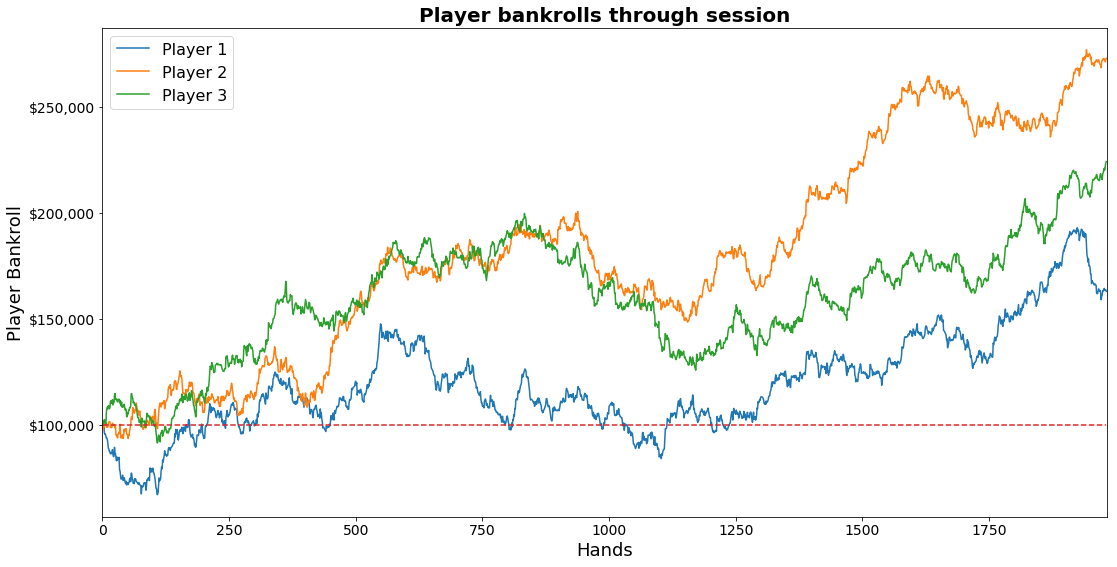

In [1357]:
simulate(num_rounds=208_000, players=['Player 1', 'Player 2', 'Player 3'], player_bankroll=100_000, 
         min_bet=25, bet_spread=16, strategy_name='hi_lo')

Option to modify:
* Num players
* Position of player
* Rulesets for all kinds of things
* Bet spread
* Scale bet spreead based on TC multiplier (harder to offer user input)
* Card counting strategy


In [1358]:
from matplotlib import pyplot as plt
from matplotlib import ticker

def plot_hands2(players, data):
    hand_num = [[i for i in range(1, len(data[0])+1)] for player in players]  # init hand num lists
    
    plt.figure(figsize=(18,9)) 

    for i, player in enumerate(players):
        plt.plot(hand_num[i], data[i])

    plt.plot([1, hand_num[0][-1]], [data[0][0], data[0][0]], linestyle='dashed')
    
    plt.xlabel('Hands', fontsize=18)
    plt.ylabel('Player Bankroll', fontsize=18)
    plt.title('Player bankrolls through session', fontweight='heavy', fontsize=20)
    
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    
    plt.xlim(0, len(data[0])+1)
    
    ax = plt.gca()
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.0f}'))
    
    plt.legend([name for name in players], fontsize=16)

In [1783]:
import numpy as np

def simulate2(num_rounds, num_sims, min_bet=1, bet_spread=8, player_bankroll=10_000, 
              players=[''], strategy_name='hi_lo'):
    
    final_bankrolls = {player:[] for player in players}
    for sim in range(num_sims):
        # Initiate the Blackjack game object
        blackjack = Blackjack(players=players, player_bankroll=player_bankroll,
                              human_player=False, print_to_terminal=False,
                              min_bet=min_bet, bet_spread=bet_spread,
                              strategy_name=strategy_name)
        
        # Play the number of rounds in sim
        for i in range(num_rounds):
            blackjack.play_round()
          
        # Add player's final bankrolls to dic
        for player in blackjack.players:
            final_bankrolls[player.name].append(player.bankroll)
        
    # Compute mean of each player and mean overall
    mean_bankrolls = {player:np.mean(final_bankrolls[player]) for player in players}
    mean_bankroll = np.mean([mean_bankrolls[key] for key in mean_bankrolls])
    
    # Compute standard deviation of each player and standard deviation overall
    std_bankrolls = {player:np.std(final_bankrolls[player]) for player in players}
    std_bankroll = np.std([bankroll for value in final_bankrolls.values() for bankroll in value])  # Confusing LC
    
    # Plot distributions
    plot_distr(final_bankrolls, mean_bankrolls, std_bankrolls, mean_bankroll, std_bankroll)
    
    # Print any other useful statistics or calculations? SCORE? Kelly Criterion needed though?
    
    for player in players:
        print('Mean final bankroll for {} was ${:,.2f}'.format(player, mean_bankrolls[player]))
        print('Standard deviation for {} was {:.2f}'.format(player, std_bankrolls[player]))
        print('')
        
    print('Overall mean: ${:,.2f} and std: {:.2f}'.format(mean_bankroll, std_bankroll))

    #pprint(final_bankrolls)
    #pprint(mean_bankrolls)
    #pprint(mean_bankroll)
    #pprint(std_bankrolls)
    #pprint(std_bankroll)

    

In [1784]:
from matplotlib import pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
from scipy.stats import norm
import numpy as np

def plot_distr(data, means, stds, mean, std):
        
    nrows = len(data)//2+1
    ncols = 2
    
    fig, axs = plt.subplots(2, 2, figsize=(20, 10))
    fig.tight_layout(pad=-5)

    # Plot distribution of final bankrolls of all players
    if len(data) > 1:
        ax = axs[0][0]
        all_data = [bankroll for value in data.values() for bankroll in value]
        
        n, bins, patches = ax.hist(all_data, bins='sqrt', color='green', density=True)
        #ax.title('All Simulations', fontweight='heavy')
        #ax.xlabel('Final bankroll')

        # Add best fit gaussian distr.    
        x = np.linspace(min(all_data), max(all_data), 100)
        y = norm.pdf(x, mean, std)
        ax.plot(x, y, color='red', linewidth=3, linestyle='dashed')
        
        
        ax.xaxis.set_minor_locator(AutoMinorLocator()) 
        
        ax.grid(axis='x', which='both')
        
        ax.set_title('All round simulations', fontsize=17)
        ax.set_xlabel('Final bankroll', fontsize=16)
        
        
    # Plot distribution of final bankrolls for each player
    for i, player in enumerate(data):
        nrow=(i+1)//2
        ncol=(i+1)%2
        ax = axs[nrow][ncol]

        ax.hist(data[player], bins='sqrt', density=True)
        
        # Add best fit gaussian distr.    
        x = np.linspace(min(data[player]), max(data[player]), 100)
        y = norm.pdf(x, mean, std)
        ax.plot(x, y, color=(1, 0.35, 0.35), linewidth=3, linestyle='dashed')
        
        ax.xaxis.set_minor_locator(AutoMinorLocator()) 

        ax.grid(axis='x', which='both')
        
        ax.set_title('{} round simulations'.format(player), fontsize=17)
        ax.set_xlabel('Final bankroll', fontsize=16)




    plt.subplots_adjust(hspace=0.2, wspace=0.2)

Mean final bankroll for Player 1 was $10,029.25
Standard deviation for Player 1 was 594.26

Mean final bankroll for Player 2 was $10,011.39
Standard deviation for Player 2 was 569.70

Mean final bankroll for Player 3 was $10,025.36
Standard deviation for Player 3 was 591.05

Overall mean: $10,022.00 and std: 585.16


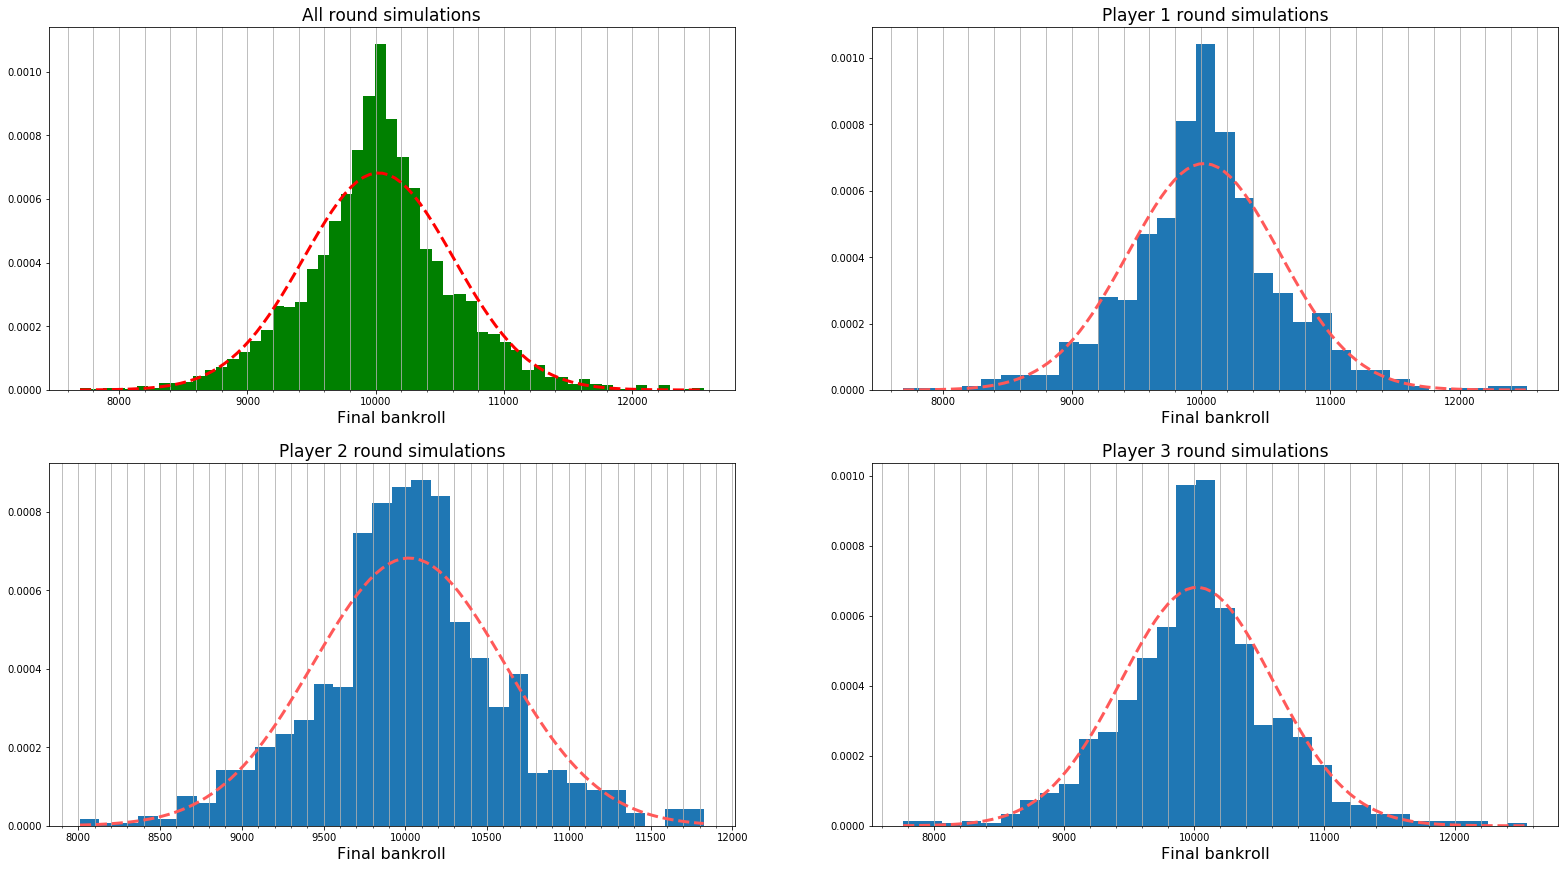

In [1791]:
simulate2(num_rounds=100, num_sims=1000, players=['Player 1', 'Player 2', 'Player 3'], player_bankroll=10_000, 
         min_bet=10, bet_spread=16, strategy_name='hi_lo')

In [1789]:
# Can use this to see how penetration impacts, player position, strategy, etc.
# Tons of possibilities. Show a few examples and leave rest for user to explore.

{'Player 1': [10024.0,
              10006.0,
              9957.5,
              9948.0,
              9972.5,
              10039.0,
              10001.0,
              9967.5,
              10011.5,
              9989.0],
 'Player 2': [10043.5,
              9983.0,
              10061.5,
              9964.5,
              10008.0,
              10022.5,
              10032.5,
              9988.0,
              10046.0,
              9994.0],
 'Player 3': [10017.5,
              10042.0,
              10009.5,
              9951.0,
              9981.0,
              10024.5,
              9970.0,
              10007.5,
              9998.5,
              9980.0]}
{'Player 1': 9991.6, 'Player 2': 10014.35, 'Player 3': 9998.15}
10001.366666666667
{'Player 1': 28.29204835284996,
 'Player 2': 30.144692733547643,
 'Player 3': 26.166820594027087}
29.822512003890992


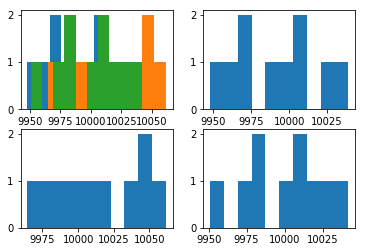

In [1504]:
simulate2(num_rounds=100, num_sims=10, players=['Player 1', 'Player 2', 'Player 3'], player_bankroll=10_000, 
         min_bet=1, bet_spread=8, strategy_name='hi_lo')

### Simulate with another strategy/ruleset ###

### Simulate with a custom ruleset ###

In [1348]:
# Player advantage - how do we define this? We could define % of time they are up or down over 1 hand?
# That would only reflect basic strategy and not payouts still. So % 

# For every $100 you bet how much will you win or lose?
# DEPENDS HOW YOU BET THE $100? BET SIZING?

# Aces and fives have the biggest effect on player/casino odds so can do ok by just counting them

# Measure expected value per 100 hands (in an hour)
# Player advantage is how much on average as a % they are up after 1 hour

# Run 10k simulations of 100 rounds
# Take standard deviation of the results too
# Plot distribution with bars and best fit of normal distribution curve based on mean and sd

# Playing more than 100 rounds would increase odds, add ability to alter that. TC=0 at start ofc. Penetration less key too

# Bet spread is key btw
# Player advantage seems to be pretty subjective

In [ ]:
# 10k bankroll and bet $1 minbet? Maybe that as baseline

In [ ]:
# - add proper interface after for results in simulation. Track variance, consider score, etc. Print metrics
# - add other card counting strategies
# - output tables as? terminal? excel? png of pandas df? Maybe terminal and save png
# - track and plot average hand payout based on count! e.g. when count is 2->2.5 we always bet 1 and made $100, lost $50
# - move to Python in vscode, move into modules, adding testing classes etc, push to Github properly with readme etc.

# can use argparse to take in inputs with flags from terminal/command prompt

In [ ]:
# Kelly Criterion, to achieve a 13.5% risk of ruin
# SCORE is an acronym, coined by Don Schlesinger, for Standardized Comparison Of Risk and Expectation. 
# It is defined as the advantage squared divided by the variance. The SCORE may also be interpreted as 
# the expected hourly win per hand for a player with a $10,000 bankroll, who sizes his bets according 
# to the Kelly Criterion, to achieve a 13.5% risk of ruin.

# https://wizardofodds.com/games/blackjack/ace-five-count/

### Possible extensions ###
Smart machine moves can be computed in 3 ways:
1. Make bet based on basic strategy
2. Make bet based on optimal play for current deck - computed by simulations
3. Make bet based on optimal play for current deck - computed by efficient combinatorics of current deck

Currently the machine player plays on basic strategy as this is a better representation of how a card counter would play in a casino. However, extending this code to play the optimal play based on remaining deck would enable odds checking vs absolute optimal play as well as optimal bet sizing using Kelly Criterion.

A closer proxy to optimal play would be to use derivatives of basic strategy based on current count. These could also be generated as an extension to this piece of work using combinatorics.

Kelly Criterion, as the most efficient bet sizing, based on current bankroll could be implemented here alongside the above. This could be replicated in casino play once derivatives of basic strategy are mastered. 

Extra rulesets could be allowed such as those found here: https://wizardofodds.com/play/blackjack-v2/ and https://www.qfit.com/blackjack-rules-surrender.htm


Implement insurance count to further get odds for AP

Could implement bet scaling / Kelly criterion

In [1380]:
# Is it faster to append and refer to a dictionary or 2 lists? Use decorator to test

from timeit import default_timer

players = ['Player 1', 'Player 2', 'Player 3']
sims = 1000000

def timer(func):
    def wrapper_timer(*args, **kwargs):
        start = default_timer()
        result = func(*args, **kwargs)
        end = default_timer()
        print('Function \'{}\' took {:.7f}s to run'.format(func.__name__, end-start))
        return result
    return wrapper_timer()
    
@timer
def test_list():
    lst = [[] for player in players]
    for sim in range(sims):
        for i, player in enumerate(players):
            lst[i].append(i)

@timer
def test_dic():
    dic = {player:[] for player in players}
    for sim in range(sims):
        for i, player in enumerate(players):
            dic[player].append(i)


# Conclusion: they are about the same so use dic/hash tables for improved readability

Function 'test_list' took 0.4578450s to run
Function 'test_dic' took 0.4471423s to run


In [1059]:
def win_or_loss():
    return random.random() <= odds_to_win

def gamble(times, starting_cash, print_cash=True):
    cash = starting_cash
    bet_size = static_bet_size
    for _ in range(times):
        bet = bet_size*cash
        if win_or_loss():
            cash += bet
        else:
            cash -= bet
        if print_cash:
            print('$ {:,.0f}'.format(cash))
            
    return cash

def gamble_kelly_criterion(times, starting_cash, print_cash=True):
    cash = starting_cash
    bet_size = (odds_to_win*2)-1
    for _ in range(times):
        bet = bet_size*cash
        if win_or_loss():
            cash += bet
        else:
            cash -= bet
        if print_cash:
            print('$ {:,.0f}'.format(cash))

            
    return cash

def test_kelly_criterion():
    '''Simple snippet to test the Kelly Criterion vs other gambling ratios'''
    import random
    odds_to_win = 0.8
    static_bet_size = 0.8

    kelly_wins = 0
    for _ in range(1000):
        result = gamble(times=100, starting_cash=1000, print_cash=False)
        result2 = gamble_kelly_criterion(times=100, starting_cash=1000, print_cash=False)
        if result2 > result:
            kelly_wins += 1


    print('Kelly criterion beats {:.0f}% bet {} times out of 1000'.format(static_bet_size*100, kelly_wins))
    

Kelly criterion beats 80% bet 670 times out of 1000


In [1056]:
def read_basic_strat():
    '''Code to convert Edward O Thorps basic strategy from 1960s Beat the Dealer to dic/JSON'''
    string='''
4	H	H	H	H	H	H	H	H	H	H
5	H	H	H	H	H	H	H	H	H	H
6	H	H	H	H	H	H	H	H	H	H
7	H	H	H	H	H	H	H	H	H	H
8	H	H	H	H	H	H	H	H	H	H
9	H	D	D	D	D	H	H	H	H	H
10	D	D	D	D	D	D	D	D	H	H
11	D	D	D	D	D	D	D	D	D	H
12	H	H	S	S	S	H	H	H	H	H
13	S	S	S	S	S	H	H	H	H	H
14	S	S	S	S	S	H	H	H	H	H
15	S	S	S	S	S	H	H	H	H	H
16	S	S	S	S	S	H	H	H	H	H
17	S	S	S	S	S	S	S	S	S	S
18	S	S	S	S	S	S	S	S	S	S
19	S	S	S	S	S	S	S	S	S	S
20	S	S	S	S	S	S	S	S	S	S
21	S	S	S	S	S	S	S	S	S	S
A,2	H	H	H	D	D	H	H	H	H	H
A,3	H	H	H	D	D	H	H	H	H	H
A,4	H	H	D	D	D	H	H	H	H	H
A,5	H	H	D	D	D	H	H	H	H	H
A,6	H	D	D	D	D	H	H	H	H	H
A,7	S	D	D	D	D	S	S	H	H	H
A,8	S	S	S	S	S	S	S	S	S	S
A,9	S	S	S	S	S	S	S	S	S	S
2,2	P	P	P	P	P	P	H	H	H	H
3,3	P	P	P	P	P	P	H	H	H	H
4,4	H	H	H	P	P	H	H	H	H	H
5,5	D	D	D	D	D	D	D	D	H	H
6,6	P	P	P	P	P	H	H	H	H	H
7,7	P	P	P	P	P	P	H	H	H	H
8,8	P	P	P	P	P	P	P	P	P	P
9,9	P	P	P	P	P	S	P	P	S	S
T,T	S	S	S	S	S	S	S	S	S	S
A,A	P	P	P	P	P	P	P	P	P	P
            '''
    
    dic = {}
    count = 12
    next_row_header = ''
    for char in string:
        if ord(char) is not 10:
            if count == 12:  # New row
                if ord(char) is not 9:
                    next_row_header += char
                else:
                    row_header = next_row_header
                    next_row_header = ''
                    dic[row_header] = {}
                    count = 2
            else:
                if ord(char) is not 9:
                    dic[row_header][count] = char
                    count += 1
                    
    for key in dic:
        print('\'{}\': '.format(key), end='')
        print(dic[key], end='')
        print(',') 